### 问题描述
- 心电信号中的基线漂移
  
  通俗的讲就是由于测量电极和人体自身呼吸的原因,会导致测出来的信号会有上下的抖动,这类抖动将难以定位ECG信号的特征点,使测出来的数据可用性降低。
- 工频干扰(50Hz)

### 数据来源：MIT-BIH 是由美国麻省理工学院提供的研究心律失常的数据库 https://physionet.org/content/mitdb/1.0.0/
- 数据描述（Data Description）：
    The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

    The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

    This directory contains the entire MIT-BIH Arrhythmia Database. About half (25 of 48 complete records, and reference annotation files for all 48 records) of this database has been freely available here since PhysioNet's inception in September 1999. The 23 remaining signal files, which had been available only on the MIT-BIH Arrhythmia Database CD-ROM, were posted here in February 2005.

- 样本选取及参数设定：这里我们读取本地的100号记录，从0到25000个样本点
  - physical=False，提取出的信号为d_signal数字信号，也就是没有转换成心电信号电压幅度之前的原始信号的值
  - physical=True，读取出每一个点的模拟信号值也就是对应采样点的mv电压值p_signal（两个一模一样的波只不过纵坐标轴的尺度不一样）
  - channels，每一次读取的数据都包含两个通道的信号可以设置为channels=[0, ]选择第一个信号,channels=[, 1]选择第二个信号,channels=[0, 1]选择两个信号

心电信号维度：(25000, 1)


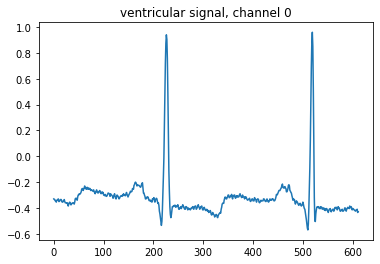

In [5]:
import wfdb
import matplotlib.pyplot as plt

record_100 = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100', sampfrom=0, sampto=25000, physical=True, channels=[0, ])
print (f'心电信号维度：{record_100.p_signal.shape}') # 这里注意信号的维度，是二维信号

ventricular_signal = record_100.p_signal[144:756]
plt.title("ventricular signal, channel 0")
plt.plot(ventricular_signal)
plt.show()

## 区域运算（平滑）
- 均值滤波
- 中值滤波
  
  中值滤波是一种非线性数字滤波器技术，经常用于去除图像或者其它信号中的杂讯。这个设计思想就是检查输入信号中的采样并判断它是否代表了信号，使用奇数个采样组成的观察窗实现这项功能。观察窗口中的数值进行排序，位于观察窗中间的中值作为输出。然后，丢弃最早的值，取得新的采样，重复上面的计算过程。

  过程：
  - 对列表里的每一个元素进行中值滤波计算,我们使用的是Python中的scipy库的signal.medfilt(滤波数据, 窗大小)
  - 参数窗的大小window_size设置为了3在一维数据中指的是以对应数为中心左右各取(window_size-1)/2个数以这些数作为滤波的基础数据，取完排序，再取中位数。
  - (window_size-1)/2为了让这个数除尽所以window_size值必须为奇数不然会报错
  - 两侧的数据在原序列中取不到，补0

  简单例子：
  window_size = 3， x = [70, 80, 30, 20, 10, 90, 0, 60, 40, 50]，step = (window_size - 1) / 2 = 1
  - 对第一个数据：[0, 70, 80] 排序-> [0, 70, 80] 取中值-> 70 -> [70, 80, 30, 20, 10, 90, 0, 60, 40, 50]
  - 对第二个数据：[70, 80, 30] 排序-> [30, 70, 80] 取中值 -> 70 -> [70, 70, 30, 20, 10, 90, 0, 60, 40, 50]
  - ...
  - 对最后一个数据：[40, 50, 0] 排序-> [0, 40, 50] 取中值 -> 40 -> [70 70 30 20 20 10 60 40 50 40]

In [6]:
import numpy as np
import scipy.signal as signal

window = 3
x = [70, 80, 30, 20, 10, 90, 0, 60, 40, 50]
y = signal.medfilt(volume=x, kernel_size=window)
print (x)
print (y)

[70, 80, 30, 20, 10, 90, 0, 60, 40, 50]
[70. 70. 30. 20. 20. 10. 60. 40. 50. 40.]


实现的对于MIT-BIH数据集的中值滤波

- MIT-BIH数据集每1秒采集360个信号，滤波器如果一次对360个数据进行处理那就是作用在了1s的信息上
- 人每次心跳差不多0.8秒/次，每一次心跳产生的信号形状都差不多，一个周期内代表一个心电信号的所包含的样值点里，取中值应该差距不大
- 所以以一个心电信号的窗的大小在整个连续的心电信号图中不断平移对信号进行处理取中值处理的话，
- 如果信号没有上下抖动(基线漂移)，那对由好几个单独的ECG信号组成的一个连续的信号中的每一个点，加窗，滤波，取得的中值所构成的线（基线，代表信号抖动程度都线）应该很平稳
- 如果差距大了说明这个信号抖了,有漂移了，那我们只需要记录下对应点的漂移情况减去这个漂移的量，把信号抻平

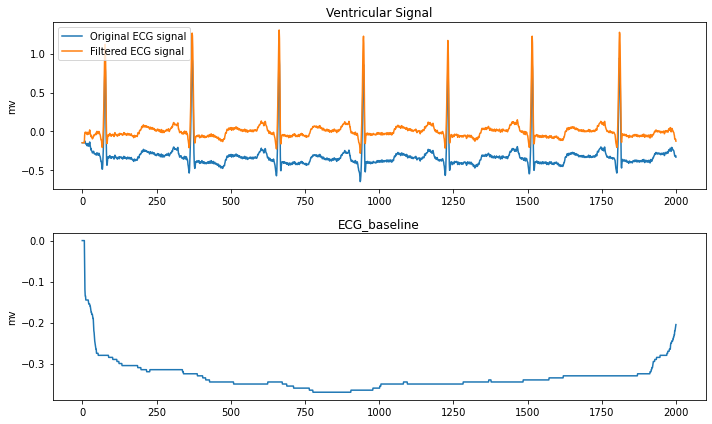

In [7]:
Original_ECG = record_100.p_signal[0:2000].flatten()
freq_MIT = 360
heart_beat_period = 0.8
ECG_baseline = signal.medfilt(volume=Original_ECG, kernel_size=int(freq_MIT*heart_beat_period)+1)
Filtered_ECG = Original_ECG - ECG_baseline

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(Original_ECG)
plt.plot(Filtered_ECG)
plt.ylabel("mv")
plt.legend(['Original ECG signal', 'Filtered ECG signal'])
plt.title("Ventricular Signal")
plt.subplot(2, 1, 2)
plt.plot(ECG_baseline)
plt.ylabel("mv")
plt.title("ECG_baseline")

plt.tight_layout()
plt.show()

发现问题：
1. 信号两边失真
- 基线两边高的原因：滤波器比较宽,在对两边的点做中值处理时,补0比较多取中值时就会有很大的误差
- 解决办法：
  1. 减小窗的尺寸，以减小补0取中值的影响，但会抹平信号大部分的特征点，失真严重（不采用）
  2. 放弃两边需要补0计算中值的特征点，认为这些信号为两边的滤波中产生的噪声直接去除掉，只要中间内一部分，Give_up_size = int(freq_MIT \* heart_beat_period/2)。基线值被抻平，信号得到很好保留不再失真（但是基线幅度值仍总体偏移）

2. 基线幅度总体偏移
- 解决办法：
  每一个点减去一下总体提升幅度值的平均值，既不会破坏抻平的信号形态，又降低了基线幅度值

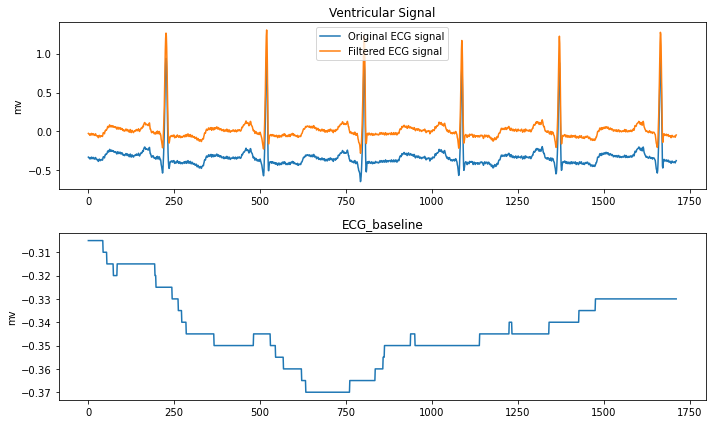

In [8]:
# 抻平基线
Give_up_size = int(freq_MIT * heart_beat_period/2)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(Original_ECG[Give_up_size:-Give_up_size])
plt.plot(Filtered_ECG[Give_up_size:-Give_up_size])
plt.ylabel("mv")
plt.legend(['Original ECG signal', 'Filtered ECG signal'])
plt.title("Ventricular Signal")
plt.subplot(2, 1, 2)
plt.plot(ECG_baseline[Give_up_size:-Give_up_size])
plt.ylabel("mv")
plt.title("ECG_baseline")

plt.tight_layout()
plt.show()

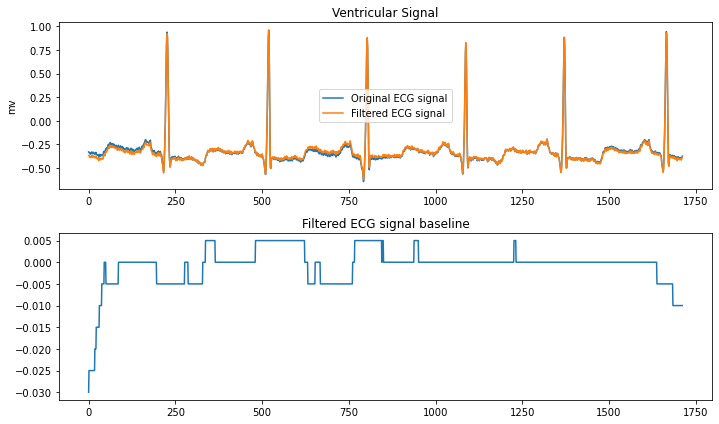

In [9]:
# 解决幅度偏移
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(Original_ECG[Give_up_size:-Give_up_size])
plt.plot(Filtered_ECG[Give_up_size:-Give_up_size] + np.mean(ECG_baseline[Give_up_size:-Give_up_size]))
plt.ylabel("mv")
plt.legend(['Original ECG signal', 'Filtered ECG signal'])
plt.title("Ventricular Signal")
plt.subplot(212)
Filtered_ECG_signal_baseline = signal.medfilt(volume=Filtered_ECG, kernel_size=int(freq_MIT*heart_beat_period)+1)
plt.plot(Filtered_ECG_signal_baseline[Give_up_size:-Give_up_size])
plt.title("Filtered ECG signal baseline")

plt.tight_layout()
plt.show()

改善后：
- 滤波之后的基线偏移量在0.03mv以内，和滤波前的偏移量0.4以内相比，提升明显
- 信号幅值没有太大变化

下面，将整个中值滤波过程封装成一个函数直接进行调用

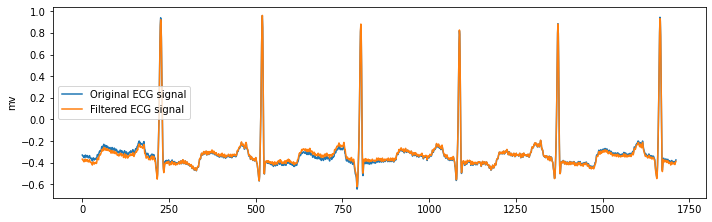

In [10]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

def medfilt_ecg(original_ecg, fs, heart_beat_period=0.8):
    """ composite median filter strategy
    Params:
    original_ecg: original ECG Ventricular signal
    fs: sampling frequency

    Returns:
    final_filtered_ecg: filtered ECG signal using composite median filter strategy
    """
    # window_size needs to be an odd number, add 1 to ensure odd if not
    window_size = int(fs*heart_beat_period)
    window_size = window_size + 1 if window_size % 2 == 0 else window_size
    give_up_size = int(window_size / 2)

    ecg_baseline = medfilt(volume=original_ecg, kernel_size=window_size)
    totality_bias = np.mean(ecg_baseline[give_up_size:-give_up_size])
    filtered_ecg = original_ecg - ecg_baseline
    final_filtered_ecg = filtered_ecg[give_up_size:-give_up_size] + totality_bias
    return final_filtered_ecg

filtered_ecg = medfilt_ecg(original_ecg=Original_ECG, fs=freq_MIT)

plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(Original_ECG[Give_up_size:-Give_up_size])
plt.plot(filtered_ecg)
plt.ylabel("mv")
plt.legend(['Original ECG signal', 'Filtered ECG signal'])

plt.tight_layout()
plt.show()